## Predictive Model 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import sklearn
import sklearn.cluster
from sklearn.decomposition import PCA
import sklearn.manifold
import sklearn.model_selection
import seaborn as sns

import sys
#sys.path.insert(0,'../')
from helper import (classification_tools as ct,
                   visualize as vis)

%matplotlib inline

In [2]:
fc1_path = Path('data','features','VGG16_fc1_features_std.pickle')
assert fc1_path.is_file()

le_path = Path('models','label_encoder.pickle')
assert le_path.is_file()


with open(fc1_path, 'rb') as f:
    data = pickle.load(f)

with open(le_path, 'rb') as f:
    le = pickle.load(f)

In [3]:
files = data['filename']
fc1 = data['features']
labels = data['labels']
y_gt = le.transform(labels)

In [4]:
n_pca=50
pca = PCA(n_components=n_pca, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=n_pca, svd_solver='full', whiten=False)
x = pca.fit_transform(fc1)
x_nw = pca_nw.fit_transform(fc1)

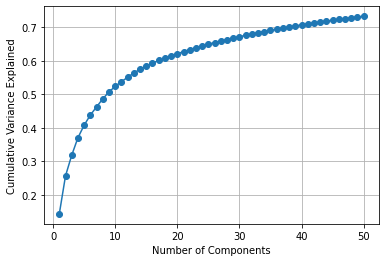

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1,n_pca+1), pca_nw.explained_variance_ratio_.cumsum(), '-o')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Variance Explained')
ax.grid(which='both')
plt.show()

## K-fold cross validation 

In [8]:
use_cache = True

kmeans_cross_val_results_cache_path_50c = Path('.neu_cache','kmeans_crossval_cache_50c.pickle')

if not use_cache or not kmeans_cross_val_results_cache_path_50c.is_file():
    rs = np.random.RandomState(seed=3732236083)
    n_splits=5
    train_acc = np.zeros(n_splits)
    val_acc = np.zeros(n_splits)
    
    kfold = sklearn.model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=rs.randint(2**16))
    splits = kfold.split(x)

    for i, (train, test) in enumerate(splits):
        
        fc1train = fc1[train]
        fc1val = fc1[test]

        Ytrain = y_gt[train]
        Yval = y_gt[test]
        
        pca_cval = PCA(n_components=50, whiten=True, svd_solver='full')
        pca_cval.fit(fc1train)
        xtrain_cval = pca_cval.transform(fc1train)
        xval_cval = pca_cval.transform(fc1val)
        
        kmeans = sklearn.cluster.KMeans(n_clusters=7, init='k-means++', n_init=500, random_state=rs.randint(2**16))
        kmeans.fit(xtrain_cval)

        labels_train = kmeans.labels_
        labels_val = kmeans.predict(xval_cval)

        Ypred_train = ct.label_matcher(labels_train, Ytrain)
        Ypred_val = ct.label_matcher(labels_val, Yval)

        train_acc[i] = (Ypred_train == Ytrain).sum()/len(Ytrain)
        val_acc[i] = (Ypred_val == Yval).sum()/len(Yval)
        
    with open(kmeans_cross_val_results_cache_path_50c, 'wb') as f:
        pickle.dump({'train_acc': train_acc,
                    'val_acc': val_acc,
                    'n_pca':n_pca},
                   f)
else:
    with open(kmeans_cross_val_results_cache_path_50c, 'rb') as f:
        results_ = pickle.load(f)
        train_acc = results_['train_acc']
        val_acc = results_['val_acc']
        n_pca = results_['n_pca']

In [9]:
print('PCA {:>3} components + whitening'.format(50))
print('Train Accuracy\t\tValidation Accuracy')
for row in zip(train_acc, val_acc):
    print("    {:.4f}\t\t\t{:.4f}".format(row[0], row[1]))


PCA  50 components + whitening
Train Accuracy		Validation Accuracy
    0.9681			0.9778
    0.9868			0.9861
    0.9611			0.9500
    0.9632			0.9583
    0.9812			0.9833


In [10]:
pca.explained_variance_ratio_.cumsum()[[34, 49]]

array([0.69069284, 0.73271936], dtype=float32)

In [11]:
use_cache = True
kmeans_cross_val_results_cache_path = Path('.neu_cache','kmeans_crossval_cache.pickle')

if not use_cache or not kmeans_cross_val_results_cache_path.is_file():
    rs = np.random.RandomState(seed=2618930764)
    n_splits=5
    train_acc = np.zeros(n_splits)
    val_acc = np.zeros(n_splits)
    
    kfold = sklearn.model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=rs.randint(2**16))
    splits = kfold.split(x)
    n_pca=35

    for i, (train, test) in enumerate(splits):
        
        fc1train = fc1[train]
        fc1val = fc1[test]

        Ytrain = y_gt[train]
        Yval = y_gt[test]
        
        pca_cval = PCA(n_components=n_pca, whiten=True, svd_solver='full')
        pca_cval.fit(fc1train)
        xtrain_cval = pca_cval.transform(fc1train)
        xval_cval = pca_cval.transform(fc1val)
        
        kmeans = sklearn.cluster.KMeans(n_clusters=7, init='k-means++', n_init=500, random_state=rs.randint(2**16))
        kmeans.fit(xtrain_cval)

        labels_train = kmeans.labels_
        labels_val = kmeans.predict(xval_cval)

        Ypred_train = ct.label_matcher(labels_train, Ytrain)
        Ypred_val = ct.label_matcher(labels_val, Yval)

        train_acc[i] = (Ypred_train == Ytrain).sum()/len(Ytrain)
        val_acc[i] = (Ypred_val == Yval).sum()/len(Yval)
        
    with open(kmeans_cross_val_results_cache_path, 'wb') as f:
        pickle.dump({'train_acc': train_acc,
                    'val_acc': val_acc,
                    'n_pca':n_pca},
                   f)
else:
    with open(kmeans_cross_val_results_cache_path, 'rb') as f:
        results_ = pickle.load(f)
        train_acc = results_['train_acc']
        val_acc = results_['val_acc']
        n_pca = results_['n_pca']

In [12]:
print('PCA {:>3} components + whitening'.format(n_pca))
print('Train Accuracy\t\tValidation Accuracy')
for i, (trainacc, valacc) in enumerate(zip(train_acc, val_acc)):
    print("    {:.4f}\t\t\t{:.4f}".format(trainacc, valacc))

PCA  35 components + whitening
Train Accuracy		Validation Accuracy
    0.9938			0.9889
    0.9889			0.9972
    0.9882			0.9694
    0.9889			0.9944
    0.9868			0.9889
